<h1 align="center">
  <b>PERIN: Permutation-invariant Semantic Parsing</b>
</h1>

<p align="center">
  <i><b>David Samuel & Milan Straka</b></i>
</p>

<p align="center">
  <i>
    Charles University<br>
    Faculty of Mathematics and Physics<br>
    Institute of Formal and Applied Linguistics
  </i>
</p>
<br>

<p align="center">
  <a href="https://arxiv.org/abs/2011.00758"><b>Paper</b></a><br>
  <a href="https://github.com/ufal/perin"><b>GitHub repository</b></a>
</p>


<p align="center">
  <img src="https://raw.githubusercontent.com/ufal/perin/main/img/illustration.png" alt="Overall architecture." width="360"/>  
</p>

# Introduction

PERIN is a universal sentence-to-graph neural network architecture modeling semantic representation from input sequences.

The main characteristics of our approach are:

- <b>Permutation-invariant model</b>: PERIN is, to our best
  knowledge, the first graph-based semantic parser that predicts all nodes at once in parallel and trains them with a permutation-invariant loss function.
- <b>Relative encoding</b>: We present a substantial improvement of relative encoding of node labels, which allows the use of a richer set of encoding rules.
- <b>Universal architecture</b>: Our work presents a general sentence-to-graph pipeline adaptable for specific frameworks only by adjusting pre-processing and post-processing steps.


Our model was ranked among the two winning systems in both the *cross-framework* and the *cross-lingual* tracks of MRP 2020 and significantly advanced the accuracy of semantic parsing from the last year's MRP 2019. 

# Interactive demo

## 1. Initialize

In [ ]:
!git clone https://github.com/ufal/perin
%cd perin

!pip3 install text2digits==0.1.0 pyonmttok==1.17.2 torchtext==0.6.0 Unidecode==1.1.1 transformers==2.10.0 pillow==7.2.0 pycnnum==1.0.1
!pip3 install git+https://github.com/cfmrp/mtool.git#egg=mtool

!curl -O https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1512/czengvallex.zip
!unzip czengvallex.zip

import os.path
import torch
import json
from IPython.display import Image
from datetime import date
from google.colab import output

import sys
sys.path.append("/content/perin")
from data.batch import Batch
from config.params import Params
from data.shared_dataset import SharedDataset
from model.model import Model

output_path = "output.mrp"
image_path = "output.png"
checkpoint = {
    "amr": {"name": "base_amr.h5", "path": "1eeDlp90DeqMW_LqieiaRN_3c76rVKkHy"},
    "drg": {"name": "base_drg.h5", "path": "1aifuh2zv62Atbl9P_8v3_l-i92wn6Fyh"},
    "eds": {"name": "base_eds.h5", "path": "1EK1y0zzlaidHC9Brm4DR9Bhd3lWHhD-B"},
    "ptg": {"name": "base_ptg.h5", "path": "1LOeCHo5lAgXxm-j-p54WMnsHtbaHlAOo"},
    "ucca": {"name": "base_ucca.h5", "path": "13fGpzlAbmNjpM8AC2EWBPFjY17qmnE7M"}
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output.clear()

## 2. Define helper methods

In [ ]:
# Load a pretrained model with dataset vocabularies
#
def load_checkpoint(framework, device):
    filename, url = checkpoint[framework]["name"], checkpoint[framework]["path"]
    if not os.path.exists(filename):
        !gdown -O {filename} https://drive.google.com/uc?id={url}
    state_dict = torch.load(filename, map_location=device)
    args = Params().load_state_dict(state_dict["args"])

    dataset = SharedDataset(args)
    dataset.load_state_dict(args, state_dict["dataset"])

    model = Model(dataset, args, initialize=False).to(device).eval()
    model.load_state_dict(state_dict["model"])
    
    return model, dataset, args



# Parse the input sentences: 
#    1) preprocess them into the correct format, 
#    2) parse them with the pretrained neural network,
#    3) postprocess into the MRP format, 
#    4) clean the output
#
def parse(input, model, dataset, args, framework, language, **kwargs):
    # preprocess
    batches = dataset.load_sentences(input, args, framework, language)
    output = batches.dataset.datasets[dataset.framework_to_id[(framework, language)]].data
    output = list(output.values())
    
    for i, batch in enumerate(batches):
        # parse and postprocess
        with torch.no_grad():
            prediction = model(Batch.to(batch, device), inference=True, **kwargs)[(framework, language)][0]

        for key, value in prediction.items():
            output[i][key] = value

        # clean the output
        output[i]["input"] = output[i]["sentence"]
        output[i] = {k: v for k, v in output[i].items() if k in {"id", "input", "nodes", "edges", "tops"}}
        output[i]["framework"] = framework
        output[i]["time"] = str(date.today())
        
    return output


# Save the parsed graph into json-like MRP format.
#
def save(output, path):
    with open(path, "w", encoding="utf8") as f:
        for sentence in output:
            json.dump(sentence, f, ensure_ascii=False)
            f.write("\n")

            
# Render and show the final semantic graph
#
def show(output_path, image_path):
    !mtool --id "0" --read mrp --write dot {output_path} "sample.txt"
    !dot -Tpng "sample.txt" > {image_path}
    !dot -Tpdf "sample.txt" > "figure.pdf"

    output.clear()
    return Image(filename=image_path) 

## 3. Parse

### AMR

In [ ]:
framework = "amr"
model, dataset, args = load_checkpoint(framework, device)

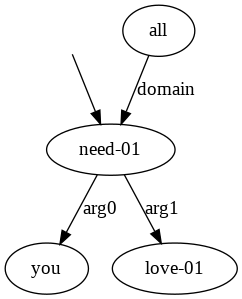

In [ ]:
sentences = ["All you need is love."]
language = "eng"  # available languages: {"eng", "zho"}

prediction = parse(sentences, model, dataset, args, framework, language, approximate_anchors=False)
save(prediction, output_path)
show(output_path, image_path)

### DRG

In [ ]:
framework = "drg"
model, dataset, args = load_checkpoint(framework, device)

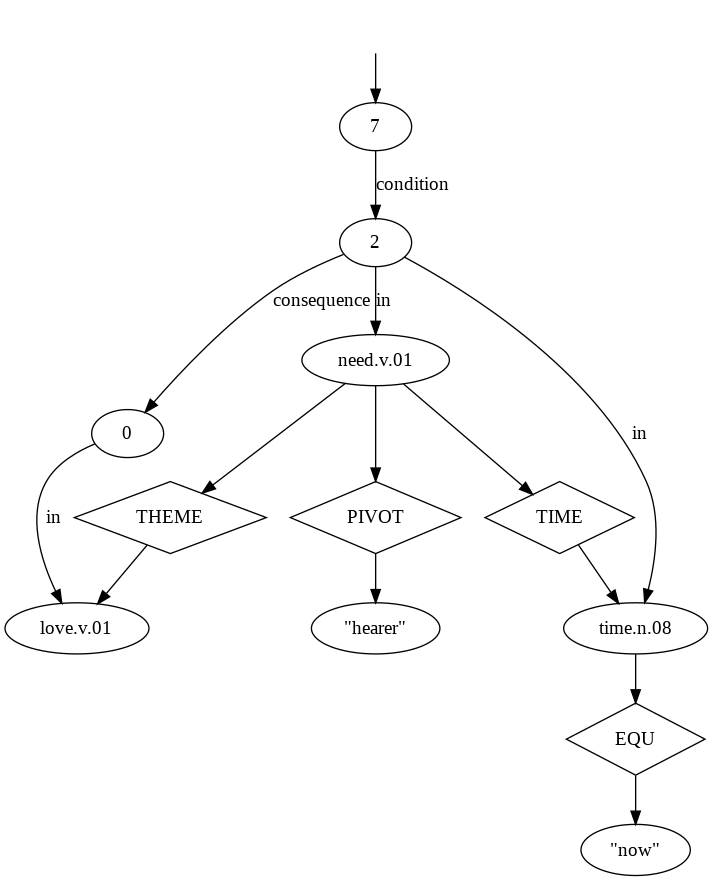

In [ ]:
sentences = ["All you need is love."]
language = "eng"  # available languages: {"eng", "deu"}

prediction = parse(sentences, model, dataset, args, framework, language)
save(prediction, output_path)
show(output_path, image_path)

### EDS

In [ ]:
framework = "eds"
model, dataset, args = load_checkpoint(framework, device)

Downloading...
From: https://drive.google.com/uc?id=1EK1y0zzlaidHC9Brm4DR9Bhd3lWHhD-B
To: /content/perin/base_eds.h5
2.34GB [00:29, 78.6MB/s]


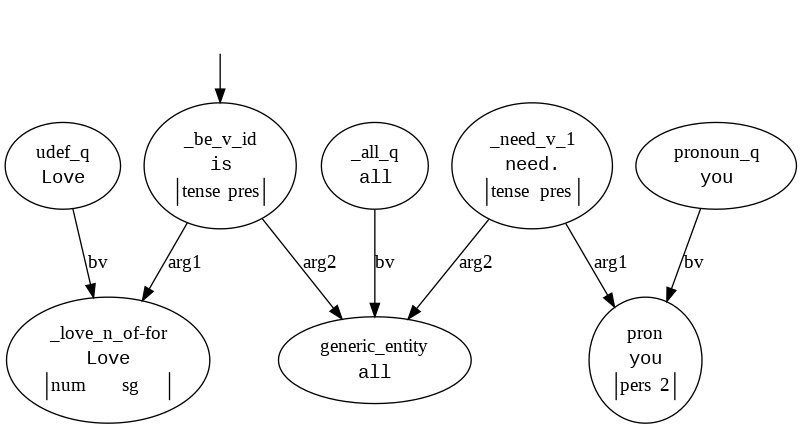

In [ ]:
sentences = ["Love is all you need."]
language = "eng"  # available languages: {"eng"}

prediction = parse(sentences, model, dataset, args, framework, language)
save(prediction, output_path)
show(output_path, image_path)

### PTG

In [ ]:
framework = "ptg"
model, dataset, args = load_checkpoint(framework, device)

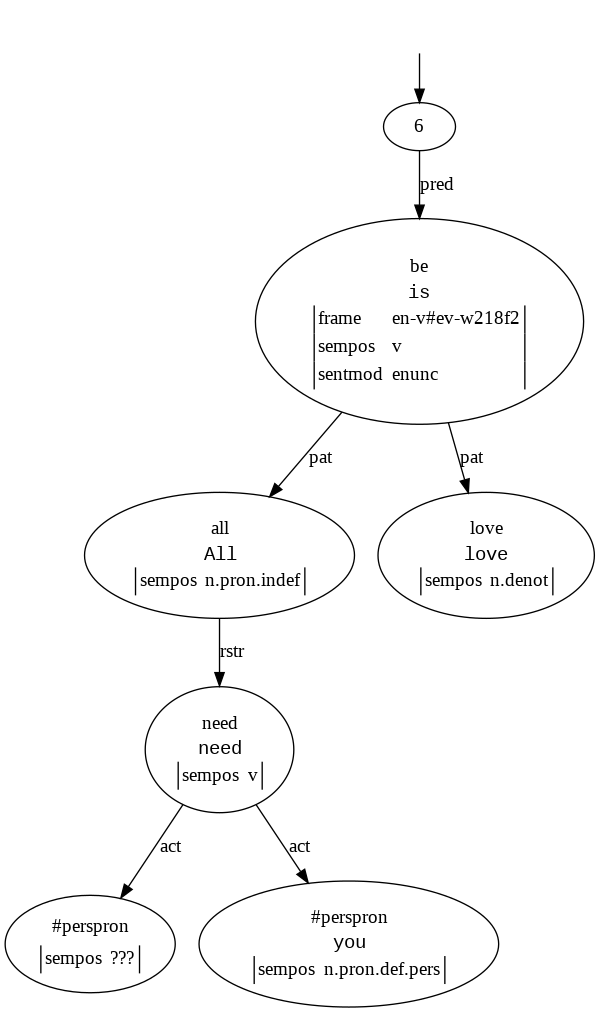

In [ ]:
sentences = ["All you need is love."]
language = "eng"  # available languages: {"eng", "ces"}

prediction = parse(sentences, model, dataset, args, framework, language)
save(prediction, output_path)
show(output_path, image_path)

### UCCA

In [ ]:
framework = "ucca"
model, dataset, args = load_checkpoint(framework, device)

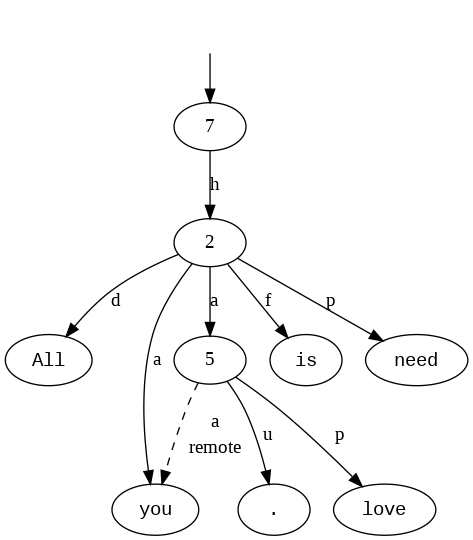

In [ ]:
sentences = ["All you need is love."]
language = "eng"  # available languages: {"eng", "deu"}

prediction = parse(sentences, model, dataset, args, framework, language)
save(prediction, output_path)
show(output_path, image_path)